In [1]:
import pandas as pd
import json
import os
import context_window_helper as cwh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
filepath = r"C:\Users\Gert\repos\CS2_cheat_detection\DataConversionPipeline\test_data\pitchtest"

# Loading csv tick data as a pd.DataFrame
match_ticks = pd.read_parquet(path=filepath+".parquet")

# Loading json event data a list of tuples (str, pd.Dataframe)
def json_2_eventlist(filepath:str) -> list:   
    with open(filepath, "r") as f:
        json_data = json.load(f)

    data = []

    for key, value in json_data.items():
        if isinstance(value, list):
            df = pd.DataFrame(value)
            data.append((key, df))

    return data

match_events = json_2_eventlist(filepath=filepath+".json")

print(match_events)

[('player_death',    assistedflash  assister_name  assister_steamid attacker_name  \
0          False            NaN               NaN       EscapeR   

    attacker_steamid  attackerblind  attackerinair   distance  dmg_armor  \
0  76561198045745648          False          False  15.135714          0   

   dmg_health  ...  revenge  thrusmoke  tick  user_name       user_steamid  \
0         134  ...        0      False  4427  Pinkvinus  76561198835783829   

   weapon     weapon_fauxitemid  weapon_itemid  weapon_originalowner_xuid wipe  
0    p250  17293822569155985444    30881983061                               0  

[1 rows x 26 columns]), ('player_connect',      bot       name        networkid  tick  user_name  user_steamid  \
0  False  Pinkvinus  [U:1:875518101]    46        NaN           NaN   

                xuid  
0  76561198835783829  ), ('player_team',    disconnect  isbot  oldteam  silent  team  tick  user_name  \
0       False  False        0   False     2   197    EscapeR

In [3]:
ticks_before_kill = 896
ticks_after_kill = 128
context_window_size = ticks_before_kill + ticks_after_kill

context_window_vals = ["attacker_X", "attacker_Y", "attacker_Z", "attacker_vel_X", "attacker_vel_Y", "attacker_vel_Z", "attacker_pitch", "attacker_yaw", "attacker_pitch_delta", 
                       "attacker_yaw_delta", "attacker_pitch_head_delta", "attacker_yaw_head_delta", "attacker_flashed", "attacker_shot", "attacker_kill", "is_kill_through_smoke", 
                       "is_kill_wallbang", "attacker_midair", "attacker_weapon_knife", "attacker_weapon_auto_rifle", "attacker_weapon_semi_rifle", "attacker_weapon_pistol",
                       "attacker_weapon_grenade", "attacker_weapon_smg", "attacker_weapon_shotgun",
                       "victim_X", "victim_Y", "victim_Z", "victim_health", "victim_noise", "map_dust2", "map_mirage", "map_inferno", "map_train",
                       "map_nuke", "map_ancient", "map_vertigo", "map_anubis", "map_office", "map_overpass", "map_basalt", "map_edin", "map_italy", "map_thera", "map_mills"]

In [4]:
match_ticks["name"]

0         EscapeR
1         EscapeR
2         EscapeR
3         EscapeR
4         EscapeR
          ...    
9453      EscapeR
9454    Pinkvinus
9455      EscapeR
9456    Pinkvinus
9457      EscapeR
Name: name, Length: 9458, dtype: object

Empty DataFrame
Columns: [flash_duration, tick]
Index: []


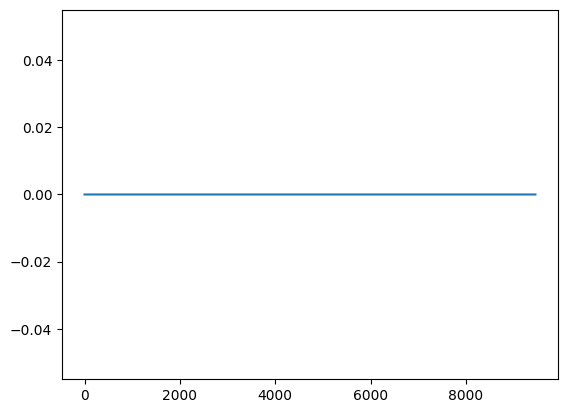

,weapon_stickers,inventory,usercmd_input_history,inventory_as_ids,approximate_spotted_by,aim_punch_angle_vel,aim_punch_angle,active_weapon_ammo,item_def_idx,weapon_quality,...,usercmd_forward_move,usercmd_consumed_server_angle_changes,is_alive,velocity_Z,active_weapon_name,usercmd_mouse_dx,game_time,tick,steamid,name
0,[],[],[],[],[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",NaN,NaN,NaN,...,NaN,NaN,False,NaN,None,NaN,3.843750,7,76561198045745648,EscapeR
1,[],[],[],[],[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",NaN,NaN,NaN,...,NaN,NaN,False,NaN,None,NaN,3.859375,8,76561198045745648,EscapeR
2,[],[],[],[],[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",NaN,NaN,NaN,...,NaN,NaN,False,0.0,None,NaN,3.875000,9,76561198045745648,EscapeR
3,[],[],[],[],[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",NaN,NaN,NaN,...,NaN,NaN,False,0.0,None,NaN,3.906250,11,76561198045745648,EscapeR
4,[],[],[],[],[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",NaN,NaN,NaN,...,NaN,NaN,False,0.0,None,NaN,3.937500,13,76561198045745648,EscapeR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9453,[],"[knife_t, P250, C4 Explosive]","[{'player_tick_count': 5168, 'player_tick_frac...","[59, 36, 49]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0.0,49.0,0.0,...,0.0,0.0,True,0.0,C4 Explosive,0.0,80.765625,4930,76561198045745648,EscapeR
9454,[],"[knife, USP-S]","[{'player_tick_count': 5169, 'player_tick_frac...","[42, 61]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",12.0,61.0,4.0,...,0.0,0.0,True,0.0,USP-S,0.0,80.781250,4931,76561198835783829,Pinkvinus
9455,[],"[knife_t, P250, C4 Explosive]","[{'player_tick_count': 5169, 'player_tick_frac...","[59, 36, 49]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",0.0,49.0,0.0,...,0.0,0.0,True,0.0,C4 Explosive,0.0,80.781250,4931,76561198045745648,EscapeR
9456,[],"[knife, USP-S]","[{'player_tick_count': 5170, 'player_tick_frac...","[42, 61]",[],"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",12.0,61.0,4.0,...,0.0,0.0,True,0.0,USP-S,0.0,80.796875,4932,76561198835783829,Pinkvinus


In [5]:
idx = match_ticks[(match_ticks["flash_duration"] > 0)&(match_ticks["name"] == "EscapeR")].index
vals = match_ticks.iloc[idx][["flash_duration", "tick"]]#.tolist()
# print(len(vals))
print(vals)

plt.plot(match_ticks[match_ticks["name"] == "EscapeR"]["flash_duration"])
plt.show()
match_ticks

# flash_duration
# flash_max_alpha
 

In [6]:
MDP = cwh.MatchDataProcessor(match_ticks)

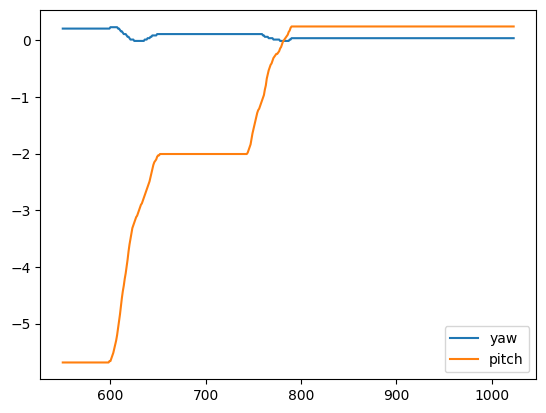

In [ ]:
# player = "Player_3" # For testug purposes, a cheater is specifically chosen
player = "EscapeR"
player_death_idx = -1


for idx, event in enumerate(match_events):
    if event[0] == "player_death":
        player_death_idx = idx
        break


player_deaths = MDP.get_player_kills(match_events, player, player_death_idx)
start_ticks, end_ticks = MDP.get_context_window_ticks(player_deaths, ticks_before_kill, ticks_after_kill)

context_window = pd.DataFrame(columns=context_window_vals)

for i in range(0,len(start_ticks)):

    # Check length of the context window and no ticks missing
    ticks = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "tick")
    if len(ticks) != context_window_size:
        gap = context_window_size - len(ticks)
        all_ticks = MDP.get_all_values_for_player(player, "tick")
        
        idx = all_ticks.index(start_ticks[i])
        end_ticks[i] = all_ticks[idx + 1024]
        

    context_window["attacker_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "X")
    context_window["attacker_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Y")
    context_window["attacker_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Z")

    context_window["attacker_vel_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_X")
    context_window["attacker_vel_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Y")
    context_window["attacker_vel_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Z")

    context_window["attacker_pitch"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "pitch")
    context_window["attacker_yaw"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "yaw")
    context_window["attacker_pitch_delta"] = MDP.get_pitch_yaw_deltas("pitch", start_ticks[i], end_ticks[i], context_window_size, player)
    context_window["attacker_yaw_delta"] = MDP.get_pitch_yaw_deltas("yaw", start_ticks[i], end_ticks[i], context_window_size, player)

    context_window["attacker_pitch_head_delta"], context_window["attacker_yaw_head_delta"] = MDP.get_pitch_yaw_head_deltas(start_ticks[i], end_ticks[i], context_window_size, player, player_deaths.iloc[i]["user_name"])

    context_window["attacker_flashed"] = MDP.get_is_player_flashed(start_ticks[i], end_ticks[i], player)

    break # Remove later, currently used for testing


plt.plot(context_window["attacker_yaw_head_delta"][550:], label='yaw')
plt.plot(context_window["attacker_pitch_head_delta"][550:], label='pitch')
plt.legend()
plt.show()

In [8]:
# Testing to see if the delta to head values are correct. They seem to be, maybe should
# do a custom test scenario


# print(player_deaths.iloc[7]["weapon"])

# plt.plot(context_window["attacker_pitch_head_delta"])
# plt.axvline(x=896)
# plt.show()

# plt.plot(context_window["attacker_yaw_head_delta"])
# plt.axvline(x=896)
# plt.show()

# plt.plot(context_window["attacker_pitch"])
# plt.show()

# plt.plot(context_window["attacker_yaw"])
# plt.show()